## Background

[Olist](https://olist.com/) is an e-commerce platform that connects merchants and their products to the marketplaces of Brazil. Merchants are able to sell their products through the Olist Store and ship them directly to customers using Olist logistics partners. 

## Problem statement

Instead of analysing the entire customer base as a whole, Olist's marketing team would like to understand the behaviour of each customer segment. A customer segmentation model (RFM framework) will allow Olist to identify users and target them with differentiated and personalised marketing strategies. This will improve user engagement and retention.

## Dataset

We will be using real commercial data provided by Olist and hosted on [Kaggle](https://www.kaggle.com/olistbr/brazilian-ecommerce). The dataset consists of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers.

## Import libraries

In [127]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

## Import data

In [128]:
customers = pd.read_csv('./datasets/olist_customers_dataset.csv')

orders = pd.read_csv('./datasets/olist_orders_dataset.csv', 
                     parse_dates=[
                         'order_purchase_timestamp', 
                         'order_approved_at', 
                         'order_delivered_carrier_date',
                         'order_delivered_customer_date',
                         'order_estimated_delivery_date'
                     ]
                    )

order_items = pd.read_csv('./datasets/olist_order_items_dataset.csv', 
                          parse_dates=[
                              'shipping_limit_date'
                          ]
                         )
order_payments = pd.read_csv('./datasets/olist_order_payments_dataset.csv')

In [129]:
dfs = [customers, orders, order_items, order_payments]

# Print shape of our datasets
for df in dfs:
    print(df.shape)

(99441, 5)
(99441, 8)
(112650, 7)
(103886, 5)


## Data cleaning

In [130]:
# Merge 4 datasets into 1 dataframe
df1 = order_items.merge(order_payments, on='order_id')
df2 = df1.merge(orders, on='order_id')
df = df2.merge(customers, on='customer_id')

In [131]:
df.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

  shipping_limit_date   price  freight_value  payment_sequential payment_type  \
0 2017-09-19 09:45:35   58.90          13.29                   1  credit_card   
1 2017-05-03 11:05:13  239.90          19.93                   1  credit_card   
2 2018-01-18 14:48:30  199.00          17.87                   1  credit_card   
3 2018-08-15 10:10:18   12.99          12.79                   1  credit_card   
4 2017-02-13 13:57:51  199.90          18.14                   1  credit_card   

   payment_installments  ...  order_status order_purchase_timestamp  \
0                     2  ...     delivered      2017-09-13 08:59:02   
1                     3  ...     delivered      2017-04-26 10:53:06   
2                     5  ...     delivered      2018-01-14 14:33:31   
3                     2  ...     delivered      2018-08-08 10:00:35   
4                     3  ...     delivered      2017-02-04 13:57:51   

    order_approved_at order_delivered_carrier_date  \
0 2017-09-13 09:45:35          2017-09-19 18:34:16   
1 2017-04-26 11:05:13          2017-05-04 14:35:00   
2 2018-01-14 14:48:30          2018-01-16 12:36:48   
3 2018-08-08 10:10:18          2018-08-10 13:28:00   
4 2017-02-04 14:10:13          2017-02-16 09:46:09   

  order_delivered_customer_date order_estimated_delivery_date  \
0           2017-09-20 23:43:48                    2017-09-29   
1           2017-05-12 16:04:24                    2017-05-15   
2           2018-01-22 13:19:16                    2018-02-05   
3           2018-08-14 13:32:39                    2018-08-20   
4           2017-03-01 16:42:31                    2017-03-17   

                 customer_unique_id customer_zip_code_prefix  \
0  871766c5855e863f6eccc05f988b23cb                    28013   
1  eb28e67c4c0b83846050ddfb8a35d051                    15775   
2  3818d81c6709e39d06b2738a8d3a2474                    35661   
3  af861d436cfc08b2c2ddefd0ba074622                    12952   
4  64b576fb70d441e8f1b2d7d446e483c5                    13226   

           customer_city  customer_state  
0  campos dos goytacazes              RJ  
1        santa fe do sul              SP  
2          para de minas              MG  
3                atibaia              SP  
4        varzea paulista              SP  

[5 rows x 22 columns]

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117601 entries, 0 to 117600
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       117601 non-null  object        
 1   order_item_id                  117601 non-null  int64         
 2   product_id                     117601 non-null  object        
 3   seller_id                      117601 non-null  object        
 4   shipping_limit_date            117601 non-null  datetime64[ns]
 5   price                          117601 non-null  float64       
 6   freight_value                  117601 non-null  float64       
 7   payment_sequential             117601 non-null  int64         
 8   payment_type                   117601 non-null  object        
 9   payment_installments           117601 non-null  int64         
 10  payment_value                  117601 non-null  float64       
 11  

In [133]:
# Check for null values
df.isnull().sum()

order_id                            0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
payment_sequential                  0
payment_type                        0
payment_installments                0
payment_value                       0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1245
order_delivered_customer_date    2567
order_estimated_delivery_date       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
dtype: int64

There are quite a few null values in `order_approved_at`, `order_delivered_carrier_date` and `order_delivered_customer_date`. Let's investigate further and decide on how we should treat these null values.

In [134]:
df[df['order_delivered_customer_date'].isnull()]['order_status'].value_counts()

order_status
shipped        1244
canceled        559
processing      375
invoiced        371
delivered         8
unavailable       7
approved          3
Name: count, dtype: int64

After some investigation, we noticed that the null values in `order_delivered_customer_date` are a result of deliveries that were not `delivered`. The `order_status` was in fact `shipped`, `canceled` etc. As we would like to build a customer segmentation model that analyses on orders that were delivered, we will only keep these orders that have fulfilled this order status.

In [135]:
# We will only keep orders that were delivered
df = df[df['order_status']=='delivered']

In [136]:
df.isnull().sum()

order_id                          0
order_item_id                     0
product_id                        0
seller_id                         0
shipping_limit_date               0
price                             0
freight_value                     0
payment_sequential                0
payment_type                      0
payment_installments              0
payment_value                     0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                15
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
customer_unique_id                0
customer_zip_code_prefix          0
customer_city                     0
customer_state                    0
dtype: int64

There are now much fewer null values than before. As the remaining null values may have been a result of a system lapse or human error, we can assume that the occurrence of missing values is random (Missing Completely at Random).

## Methodology

We will use the RFM framework to build our customer segmentation model. RFM stands for Recency, Frequency, Monetary Value. This would allow us to create the following segments:

- Low Value: Customers who are less active than others, not very frequent buyers and generate very low revenue.

- Mid Value: In the middle of everything. Uses the platform fairly frequently and generates moderate revenue.

- High Value: The group we don’t want to lose. High Revenue, Frequency and Low Inactivity.

## Recency

Recency can be calculated by finding the number of days since customers' last purchase. After obtaining the number of inactive days, we can apply K-means clustering to assign each customer a recency score.

In [137]:
# Create a dataframe to store customers uuid and recency scores
recency = df[['customer_unique_id', 'order_purchase_timestamp']].copy()

In [138]:
# Since a customer may have more than one order, we will obtain his/her last purchase timestamp
recency = recency.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()
recency.columns = ['customer_unique_id', 'last_purchase_timestamp']

# Calculate the number of days since customers' last purchase
recency['inactive_days'] = (recency['last_purchase_timestamp'].max() - recency['last_purchase_timestamp']).dt.days
recency.drop(columns='last_purchase_timestamp', inplace=True)

C:\Users\Shamika Tissera\AppData\Local\Temp\ipykernel_23840\4225387926.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




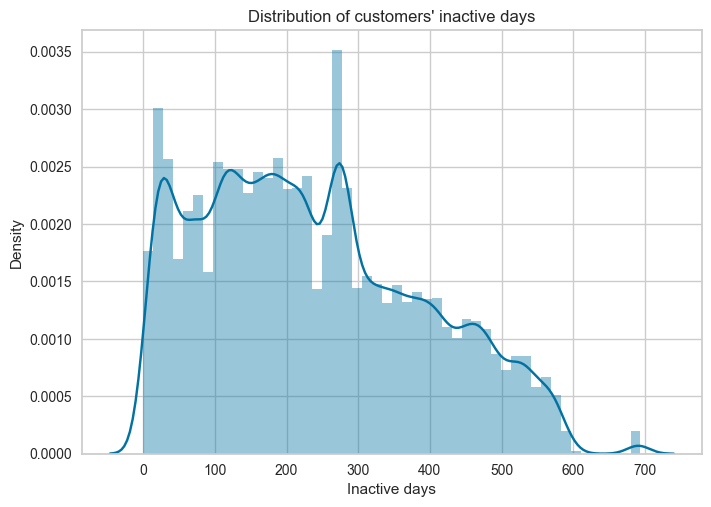

In [139]:
sns.distplot(recency['inactive_days'], bins=50)
plt.xlabel('Inactive days')
plt.ylabel('Density')
plt.title("Distribution of customers' inactive days");

We will use K-means clustering to assign each customer with a recency score. But first, we will use the elbow method to identify the optimal number of clusters here.

In [140]:
inertia = {}

for k in range(1,10):
    km = KMeans(n_clusters=k)
    km = km.fit(recency[['inactive_days']])
    inertia[k] = km.inertia_

C:\Users\Shamika Tissera\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Shamika Tissera\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Shamika Tissera\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Shamika Tissera\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

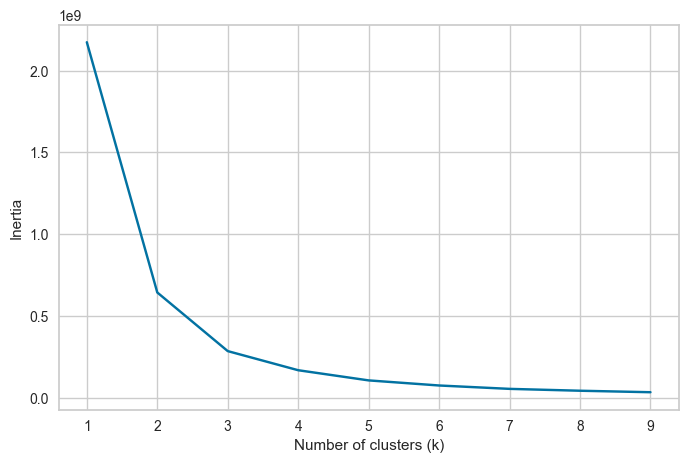

In [141]:
plt.figure(figsize=(8,5))
plt.plot(list(inertia.keys()), list(inertia.values()))
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia');

Given that the elbow on the arm is the optimal k, the optimal number of clusters for Recency is 3. However, as we would see later on, the optimal k for Frequency and Monetary is 4. Hence, we will go with 4 clusters for consistency.

In [142]:
km = KMeans(n_clusters=4, random_state=42)
km.fit(recency[['inactive_days']])
recency['cluster'] = km.labels_

C:\Users\Shamika Tissera\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [143]:
recency.head()

customer_unique_id  inactive_days  cluster
0  0000366f3b9a7992bf8c76cfdf3221e2            111        2
1  0000b849f77a49e4a4ce2b2a4ca5be3f            114        2
2  0000f46a3911fa3c0805444483337064            536        1
3  0000f6ccb0745a6a4b88665a16c9f078            320        3
4  0004aac84e0df4da2b147fca70cf8255            287        3

In [144]:
recency.groupby('cluster')['inactive_days'].describe().sort_values(by='mean')

count        mean        std    min    25%    50%    75%    max
cluster                                                                   
2        25348.0   61.224712  35.810246    0.0   28.0   61.0   94.0  121.0
0        27129.0  182.690368  35.207229  122.0  153.0  182.0  213.0  247.0
3        24270.0  313.020766  43.167006  248.0  276.0  306.0  350.0  397.0
1        16610.0  482.513666  58.840875  398.0  435.0  474.0  525.0  694.0

As seen above, the cluster labels do not intuitively represent the inactive days. Let's assign cluster 0 to the highly inactive customers and cluster 4 to the most active customers.

In [145]:
# Renaming the clusters according to mean number of inactive_days
recency_cluster = recency.groupby('cluster')['inactive_days'].mean().reset_index()
recency_cluster = recency_cluster.sort_values(by='inactive_days', ascending=False).reset_index(drop=True)
recency_cluster['index'] = np.arange(0,4)
recency_cluster.set_index('cluster', inplace=True)
cluster_dict = recency_cluster['index'].to_dict()
recency['cluster'].replace(cluster_dict, inplace=True)

In [146]:
# Check that the clusters have been renamed correctly
recency.head()

customer_unique_id  inactive_days  cluster
0  0000366f3b9a7992bf8c76cfdf3221e2            111        3
1  0000b849f77a49e4a4ce2b2a4ca5be3f            114        3
2  0000f46a3911fa3c0805444483337064            536        0
3  0000f6ccb0745a6a4b88665a16c9f078            320        1
4  0004aac84e0df4da2b147fca70cf8255            287        1

In [147]:
recency.groupby('cluster')['inactive_days'].describe().sort_values(by='mean')

count        mean        std    min    25%    50%    75%    max
cluster                                                                   
3        25348.0   61.224712  35.810246    0.0   28.0   61.0   94.0  121.0
2        27129.0  182.690368  35.207229  122.0  153.0  182.0  213.0  247.0
1        24270.0  313.020766  43.167006  248.0  276.0  306.0  350.0  397.0
0        16610.0  482.513666  58.840875  398.0  435.0  474.0  525.0  694.0

Nice, the cluster labels now make more sense. Cluster 3 are our most valued customers as they have completed a more recent transaction compared to customers from the other clusters.

## Frequency

We will count the number of unique orders made by each customer to obtain their purchase frequencies.

In [148]:
# Create a dataframe to store customers uuid and frequency scores
frequency = df[['customer_unique_id', 'order_id']].copy()

In [149]:
# Count the number of orders for each customer
frequency = frequency.groupby('customer_unique_id')['order_id'].count().reset_index()
frequency.columns = ['customer_unique_id', 'number_of_orders']

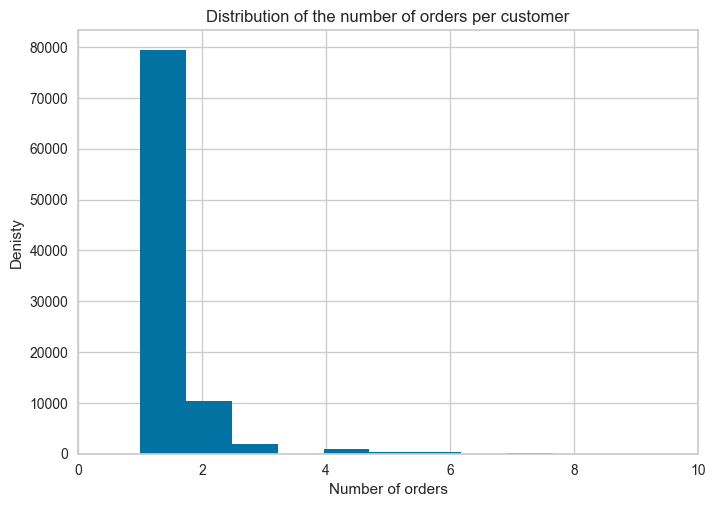

In [150]:
frequency['number_of_orders'].plot.hist(bins=100)
plt.xlim(0,10)
plt.xlabel('Number of orders')
plt.ylabel('Denisty')
plt.title('Distribution of the number of orders per customer');

In [151]:
inertia = {}

for k in range(1,10):
    km = KMeans(n_clusters=k)
    km = km.fit(frequency[['number_of_orders']])
    inertia[k] = km.inertia_

C:\Users\Shamika Tissera\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Shamika Tissera\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Shamika Tissera\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Shamika Tissera\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

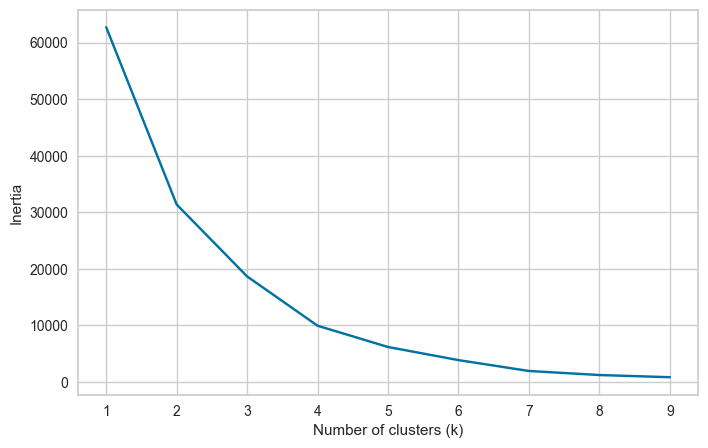

In [152]:
plt.figure(figsize=(8,5))
plt.plot(list(inertia.keys()), list(inertia.values()))
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia');

The optimal number of clusters for Frequency is 4.

In [153]:
km = KMeans(n_clusters=4, random_state=42)
km.fit(frequency[['number_of_orders']])
frequency['cluster'] = km.labels_

C:\Users\Shamika Tissera\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [154]:
frequency.groupby('cluster')['number_of_orders'].describe().sort_values(by='mean')

count      mean        std   min   25%   50%   75%   max
cluster                                                            
0        79337.0   1.00000   0.000000   1.0   1.0   1.0   1.0   1.0
2        12325.0   2.15497   0.361890   2.0   2.0   2.0   2.0   3.0
1         1656.0   5.05314   1.630029   4.0   4.0   4.0   6.0  12.0
3           39.0  19.74359  10.774526  13.0  14.0  16.0  21.0  75.0

Just like Recency, the given cluster labels in Frequency are not intuitive.

We will reassign the labels here. Customers that have made only 1 order will be assigned to cluster 0 while the cluster that has an average of 14.5 orders will be assigned to cluster 3.

In [155]:
# Renaming the clusters according the mean number_of_orders
frequency_cluster = frequency.groupby('cluster')['number_of_orders'].mean().reset_index()
frequency_cluster = frequency_cluster.sort_values(by='number_of_orders').reset_index(drop=True)
frequency_cluster['index'] = np.arange(0,4)
frequency_cluster.set_index('cluster', inplace=True)
cluster_dict = frequency_cluster['index'].to_dict()
frequency['cluster'].replace(cluster_dict, inplace=True)

In [156]:
frequency.groupby('cluster')['number_of_orders'].describe().sort_values(by='mean')

count      mean        std   min   25%   50%   75%   max
cluster                                                            
0        79337.0   1.00000   0.000000   1.0   1.0   1.0   1.0   1.0
1        12325.0   2.15497   0.361890   2.0   2.0   2.0   2.0   3.0
2         1656.0   5.05314   1.630029   4.0   4.0   4.0   6.0  12.0
3           39.0  19.74359  10.774526  13.0  14.0  16.0  21.0  75.0

Cluster 3 are the highest frequency customers.

## Monetary

In [157]:
# Create a dataframe to store customer uuid and monetary scores
monetary = df[['customer_unique_id', 'payment_value']].copy()

In [158]:
# Total payment value per customer
monetary = monetary.groupby('customer_unique_id')['payment_value'].sum().reset_index()

C:\Users\Shamika Tissera\AppData\Local\Temp\ipykernel_23840\2952267249.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




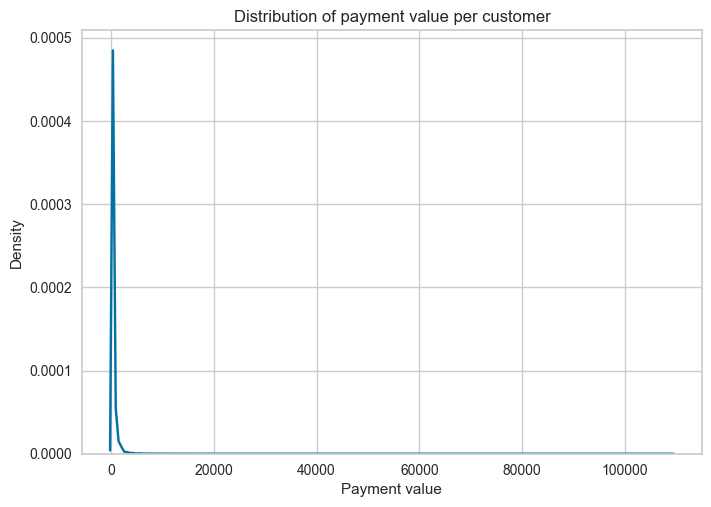

In [159]:
sns.distplot(monetary['payment_value'], hist=False)
plt.xlabel('Payment value')
plt.ylabel('Density')
plt.title('Distribution of payment value per customer');

In [160]:
inertia = {}

for k in range(1,10):
    km = KMeans(n_clusters=k)
    km = km.fit(monetary[['payment_value']])
    inertia[k] = km.inertia_

C:\Users\Shamika Tissera\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Shamika Tissera\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Shamika Tissera\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Shamika Tissera\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

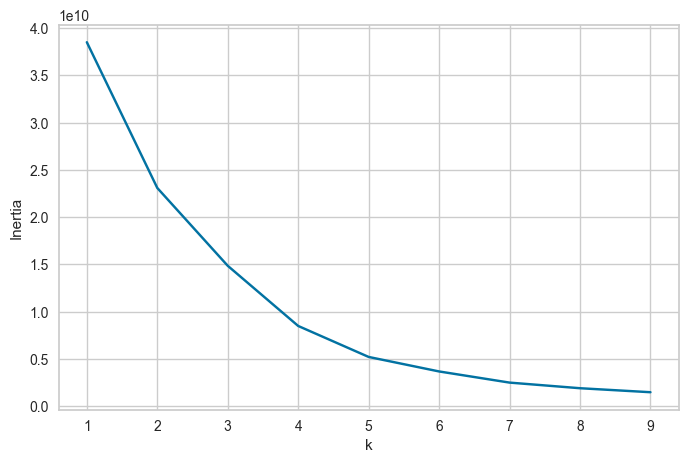

In [161]:
plt.figure(figsize=(8,5))
plt.plot(list(inertia.keys()), list(inertia.values()))
plt.xlabel('k')
plt.ylabel('Inertia');

In [162]:
km = KMeans(n_clusters=4, random_state=42)
km.fit(monetary[['payment_value']])
monetary['cluster'] = km.labels_

C:\Users\Shamika Tissera\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [163]:
monetary

customer_unique_id  payment_value  cluster
0      0000366f3b9a7992bf8c76cfdf3221e2         141.90        0
1      0000b849f77a49e4a4ce2b2a4ca5be3f          27.19        0
2      0000f46a3911fa3c0805444483337064          86.22        0
3      0000f6ccb0745a6a4b88665a16c9f078          43.62        0
4      0004aac84e0df4da2b147fca70cf8255         196.89        0
...                                 ...            ...      ...
93352  fffcf5a5ff07b0908bd4e2dbc735a684        4134.84        3
93353  fffea47cd6d3cc0a88bd621562a9d061          84.58        0
93354  ffff371b4d645b6ecea244b27531430a         112.46        0
93355  ffff5962728ec6157033ef9805bacc48         133.69        0
93356  ffffd2657e2aad2907e67c3e9daecbeb          71.56        0

[93357 rows x 3 columns]

In [164]:
monetary.groupby('cluster')['payment_value'].describe().sort_values(by='mean')

count           mean          std        min        25%        50%  \
cluster                                                                         
0        92075.0     172.485052   190.123221       9.59      63.27     111.37   
3         1261.0    2633.825139  1651.695281    1404.41    1645.76    2027.65   
1           20.0   23201.656000  9512.025508   14196.28   16880.72   19258.32   
2            1.0  109312.640000          NaN  109312.64  109312.64  109312.64   

                75%        max  
cluster                         
0           195.860    1401.85  
3          2895.000   12490.88  
1         28226.475   45256.00  
2        109312.640  109312.64

Yet again, we witness that the assigned cluster labels do best represent customers' monetary value. We will rename these clusters.

In [165]:
# Renaming the clusters according to mean number of payment_value
monetary_cluster = monetary.groupby('cluster')['payment_value'].mean().reset_index()
monetary_cluster = monetary_cluster.sort_values(by='payment_value').reset_index(drop=True)
monetary_cluster['index'] = np.arange(0,4)
monetary_cluster.set_index('cluster', inplace=True)
cluster_dict = monetary_cluster['index'].to_dict()
monetary['cluster'].replace(cluster_dict, inplace=True)

In [166]:
monetary.groupby('cluster')['payment_value'].describe().sort_values(by='mean')

count           mean          std        min        25%        50%  \
cluster                                                                         
0        92075.0     172.485052   190.123221       9.59      63.27     111.37   
1         1261.0    2633.825139  1651.695281    1404.41    1645.76    2027.65   
2           20.0   23201.656000  9512.025508   14196.28   16880.72   19258.32   
3            1.0  109312.640000          NaN  109312.64  109312.64  109312.64   

                75%        max  
cluster                         
0           195.860    1401.85  
1          2895.000   12490.88  
2         28226.475   45256.00  
3        109312.640  109312.64

Clusters 2 and 3 are our biggest spending customers.

In [167]:
################################

In [168]:
rfm = recency.merge(frequency, on='customer_unique_id')
rfm = rfm.merge(monetary, on='customer_unique_id')

# keep only the RFM columns
rfm = rfm[['customer_unique_id', 'inactive_days', 'number_of_orders', 'payment_value']]

# rename the columns
rfm.columns = ['customer_unique_id', 'recency', 'frequency', 'monetary']

rfm.describe()

recency     frequency       monetary
count  93357.000000  93357.000000   93357.000000
mean     236.936673      1.232205     211.833718
std      152.584315      0.819763     642.166523
min        0.000000      1.000000       9.590000
25%      113.000000      1.000000      63.760000
50%      218.000000      1.000000     112.950000
75%      345.000000      1.000000     201.740000
max      694.000000     75.000000  109312.640000

In [169]:
import prince
import pandas as pd # dataframe manipulation
import numpy as np # linear algebra

# data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

# sklearn 
from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples, accuracy_score, classification_report

from pyod.models.ecod import ECOD
from yellowbrick.cluster import KElbowVisualizer

import lightgbm as lgb
import prince





def get_pca_2d(df, predict):

    pca_2d_object = prince.PCA(
    n_components=2,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_2d_object.fit(df)

    df_pca_2d = pca_2d_object.transform(df)
    df_pca_2d.columns = ["comp1", "comp2"]
    df_pca_2d["cluster"] = predict

    return pca_2d_object, df_pca_2d



def get_pca_3d(df, predict):

    pca_3d_object = prince.PCA(
    n_components=3,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_3d_object.fit(df)

    df_pca_3d = pca_3d_object.transform(df)
    df_pca_3d.columns = ["comp1", "comp2", "comp3"]
    df_pca_3d["cluster"] = predict

    return pca_3d_object, df_pca_3d



def plot_pca_3d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    fig = px.scatter_3d(df, 
                        x='comp1', 
                        y='comp2', 
                        z='comp3',
                        color='cluster',
                        template="plotly",
                        
                        # symbol = "cluster",
                        
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 4,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 1000, 
                                height = 800, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            zaxis=dict(title = 'comp3', titlefont_color = 'black')),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                      
    
    fig.show()


def plot_pca_2d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    fig = px.scatter(df, 
                        x='comp1', 
                        y='comp2', 
                        color='cluster',
                        template="plotly",
                        # symbol = "cluster",
                        
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 8,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 800, 
                                height = 700, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            ),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                        
        
    fig.show()


In [170]:
rfm

customer_unique_id  recency  frequency  monetary
0      0000366f3b9a7992bf8c76cfdf3221e2      111          1    141.90
1      0000b849f77a49e4a4ce2b2a4ca5be3f      114          1     27.19
2      0000f46a3911fa3c0805444483337064      536          1     86.22
3      0000f6ccb0745a6a4b88665a16c9f078      320          1     43.62
4      0004aac84e0df4da2b147fca70cf8255      287          1    196.89
...                                 ...      ...        ...       ...
93352  fffcf5a5ff07b0908bd4e2dbc735a684      446          2   4134.84
93353  fffea47cd6d3cc0a88bd621562a9d061      261          1     84.58
93354  ffff371b4d645b6ecea244b27531430a      567          1    112.46
93355  ffff5962728ec6157033ef9805bacc48      118          1    133.69
93356  ffffd2657e2aad2907e67c3e9daecbeb      483          1     71.56

[93357 rows x 4 columns]

In [171]:
from pyod.models.ecod import ECOD
# https://github.com/yzhao062/pyod

clf = ECOD()
clf.fit(rfm.iloc[:, 1:])


out = clf.predict(rfm.iloc[:, 1:]) 
rfm["outliers"] = out
# rfm["outliers"] = out

rfm_no_out = rfm[rfm["outliers"] == 0]
rfm_no_out = rfm_no_out.drop(["outliers"], axis = 1)

# df_embedding_no_out = rfm[rfm["outliers"] == 0]
# df_embedding_no_out = df_embedding_no_out.drop(["outliers"], axis = 1)

rfm_with_out = rfm.copy()
rfm_with_out = rfm_with_out.drop(["outliers"], axis = 1)

In [172]:
rfm_no_out

customer_unique_id  recency  frequency  monetary
0      0000366f3b9a7992bf8c76cfdf3221e2      111          1    141.90
1      0000b849f77a49e4a4ce2b2a4ca5be3f      114          1     27.19
2      0000f46a3911fa3c0805444483337064      536          1     86.22
3      0000f6ccb0745a6a4b88665a16c9f078      320          1     43.62
4      0004aac84e0df4da2b147fca70cf8255      287          1    196.89
...                                 ...      ...        ...       ...
93351  fffbf87b7a1a6fa8b03f081c5f51a201      244          1    167.32
93353  fffea47cd6d3cc0a88bd621562a9d061      261          1     84.58
93354  ffff371b4d645b6ecea244b27531430a      567          1    112.46
93355  ffff5962728ec6157033ef9805bacc48      118          1    133.69
93356  ffffd2657e2aad2907e67c3e9daecbeb      483          1     71.56

[84021 rows x 4 columns]

In [173]:
#### Kmeans

In [174]:
from sklearn.cluster import KMeans

In [175]:
n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(rfm_no_out.iloc[:, 1:])
rfm_no_out["cluster"] = kmeans.labels_

C:\Users\Shamika Tissera\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [176]:
# min max scaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

rfm_no_out.iloc[:, 1:4] = scaler.fit_transform(rfm_no_out.iloc[:, 1:4])
rfm_no_out

customer_unique_id   recency  frequency  monetary  \
0      0000366f3b9a7992bf8c76cfdf3221e2  0.181347        0.0  0.056909   
1      0000b849f77a49e4a4ce2b2a4ca5be3f  0.186528        0.0  0.003114   
2      0000f46a3911fa3c0805444483337064  0.915371        0.0  0.030797   
3      0000f6ccb0745a6a4b88665a16c9f078  0.542314        0.0  0.010819   
4      0004aac84e0df4da2b147fca70cf8255  0.485320        0.0  0.082697   
...                                 ...       ...        ...       ...   
93351  fffbf87b7a1a6fa8b03f081c5f51a201  0.411054        0.0  0.068830   
93353  fffea47cd6d3cc0a88bd621562a9d061  0.440415        0.0  0.030028   
93354  ffff371b4d645b6ecea244b27531430a  0.968912        0.0  0.043102   
93355  ffff5962728ec6157033ef9805bacc48  0.193437        0.0  0.053058   
93356  ffffd2657e2aad2907e67c3e9daecbeb  0.823834        0.0  0.023922   

       cluster  
0            0  
1            0  
2            2  
3            2  
4            2  
...        ...  
93351        0  
93353        2  
93354        2  
93355        0  
93356        2  

[84021 rows x 5 columns]

In [179]:
rfm_no_out.iloc[:, 1:4]

recency  frequency  monetary
0      0.181347        0.0  0.056909
1      0.186528        0.0  0.003114
2      0.915371        0.0  0.030797
3      0.542314        0.0  0.010819
4      0.485320        0.0  0.082697
...         ...        ...       ...
93351  0.411054        0.0  0.068830
93353  0.440415        0.0  0.030028
93354  0.968912        0.0  0.043102
93355  0.193437        0.0  0.053058
93356  0.823834        0.0  0.023922

[84021 rows x 3 columns]

In [180]:
import prince

pca_3d_object, df_pca_3d = get_pca_3d(rfm_no_out.iloc[:, 1:4], rfm_no_out["cluster"])
plot_pca_3d(df_pca_3d, title = "PCA Space", opacity=1, width_line = 0.1)
print("The variability is :", pca_3d_object.eigenvalues_summary)

The variability is :           eigenvalue % of variance % of variance (cumulative)
component                                                    
0              1.179        39.31%                     39.31%
1              0.999        33.31%                     72.62%
2              0.822        27.38%                    100.00%


In [52]:
# Agglomerative Clustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Sample a subset of the data
sample_size = 10000
rfm_sample = rfm_no_out.sample(n=sample_size, random_state=0)

# Generate the linkage matrix
Z = linkage(rfm_sample.iloc[:, 1:], 'ward')


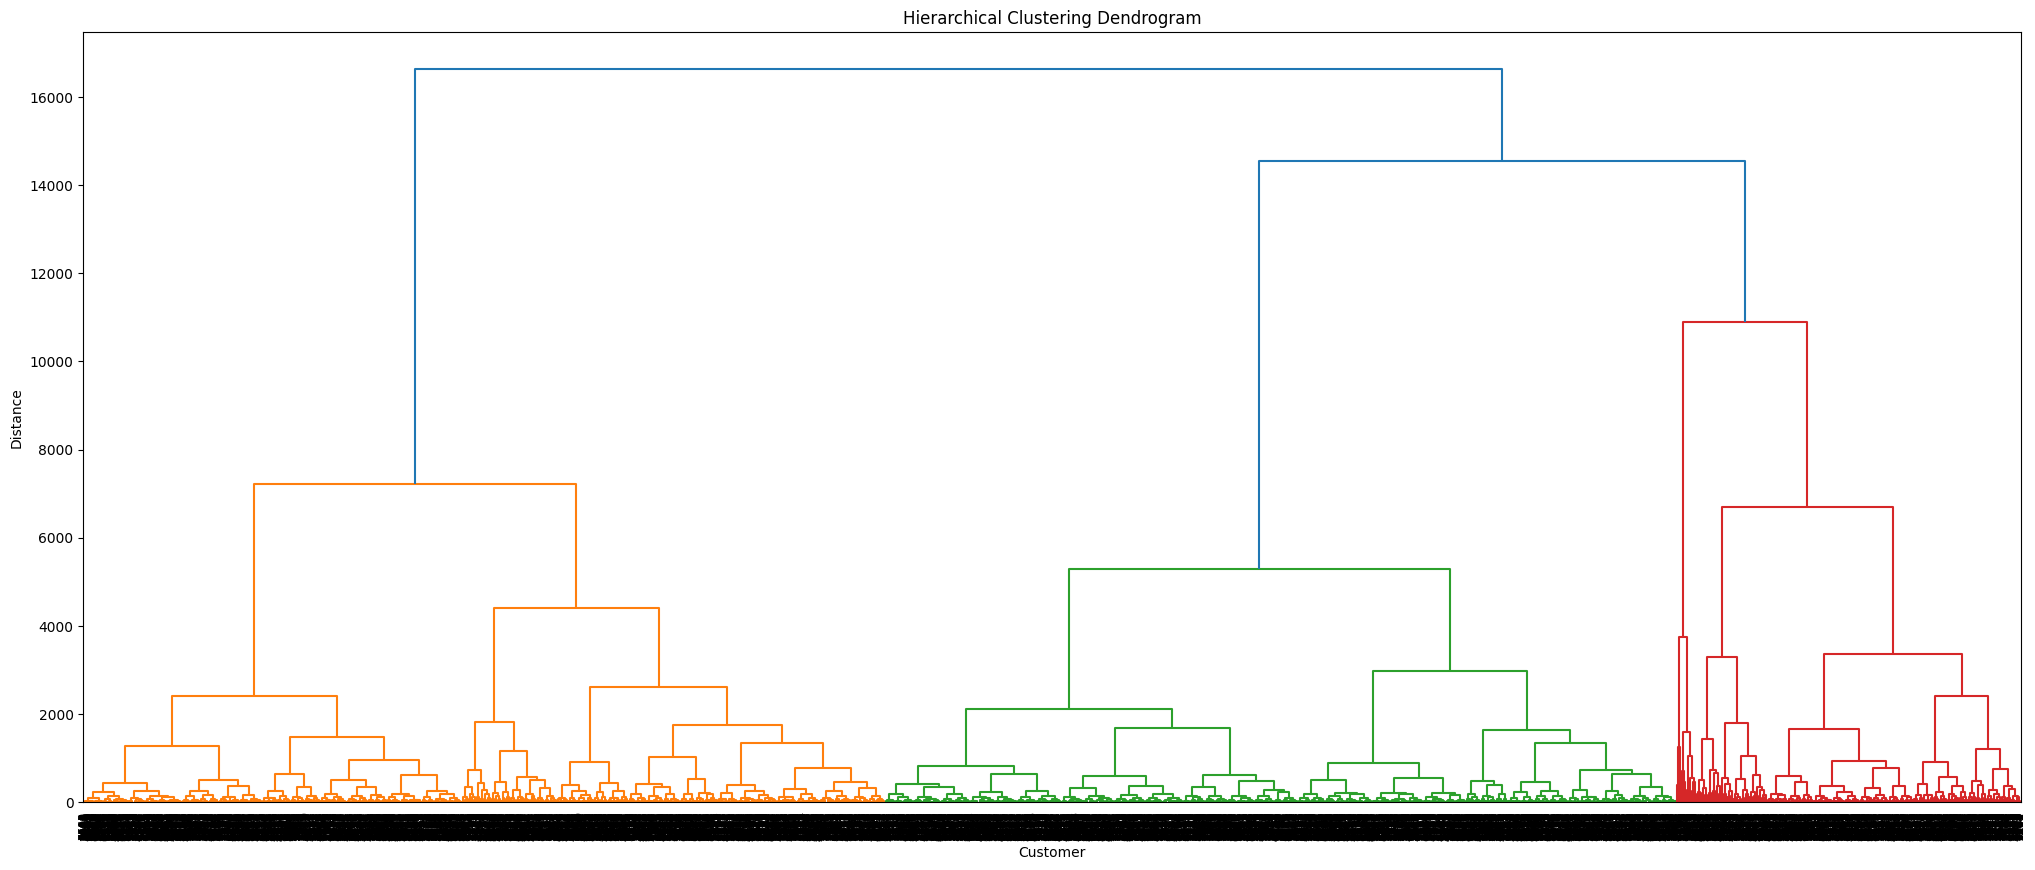

In [53]:
# Plot the dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Customer')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90., leaf_font_size=8.)
plt.show()


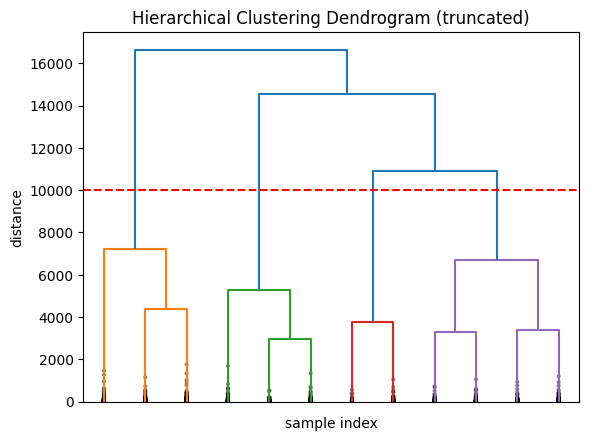

In [54]:

plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    color_threshold=10000,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.axhline(10000, c='r', ls='--')
plt.show()


In [ ]:
################################

## Overall score

In [107]:
# Merge recency, frequency and monetary dataframes together on customer uuid
overall = recency.merge(frequency, on='customer_unique_id')
overall = overall.merge(monetary, on='customer_unique_id')

# Rename cluster columns
overall.rename(columns={'cluster_x': 'recency_cluster',
                       'cluster_y': 'frequency_cluster',
                       'cluster': 'monetary_cluster'},
              inplace=True)

# Sum up the clusters to obtain the overall score
overall['overall_score'] = overall['recency_cluster'] + overall['frequency_cluster'] + overall['monetary_cluster']

In [108]:
overall

customer_unique_id  inactive_days  recency_cluster  \
0      0000366f3b9a7992bf8c76cfdf3221e2            111                3   
1      0000b849f77a49e4a4ce2b2a4ca5be3f            114                3   
2      0000f46a3911fa3c0805444483337064            536                0   
3      0000f6ccb0745a6a4b88665a16c9f078            320                1   
4      0004aac84e0df4da2b147fca70cf8255            287                1   
...                                 ...            ...              ...   
93352  fffcf5a5ff07b0908bd4e2dbc735a684            446                0   
93353  fffea47cd6d3cc0a88bd621562a9d061            261                1   
93354  ffff371b4d645b6ecea244b27531430a            567                0   
93355  ffff5962728ec6157033ef9805bacc48            118                3   
93356  ffffd2657e2aad2907e67c3e9daecbeb            483                0   

       number_of_orders  frequency_cluster  payment_value  monetary_cluster  \
0                     1                  0         141.90                 0   
1                     1                  0          27.19                 0   
2                     1                  0          86.22                 0   
3                     1                  0          43.62                 0   
4                     1                  0         196.89                 0   
...                 ...                ...            ...               ...   
93352                 2                  1        4134.84                 1   
93353                 1                  0          84.58                 0   
93354                 1                  0         112.46                 0   
93355                 1                  0         133.69                 0   
93356                 1                  0          71.56                 0   

       overall_score  
0                  3  
1                  3  
2                  0  
3                  1  
4                  1  
...              ...  
93352              2  
93353              1  
93354              0  
93355              3  
93356              0  

[93357 rows x 8 columns]

In [61]:
overall.groupby('overall_score')[['inactive_days', 'number_of_orders', 'payment_value']].mean()

inactive_days  number_of_orders  payment_value
overall_score                                                
0                 482.492924          1.000000     141.210948
1                 329.210759          1.104099     166.967417
2                 201.872528          1.173245     177.027617
3                  83.704086          1.228152     200.314990
4                  83.605918          2.480230     555.643886
5                  98.917384          4.674699    1932.910585
6                  79.273256          7.005814    4470.745407
7                 100.333333          9.500000   25650.098333
8                  21.000000         24.000000   27935.460000

We have now assigned customers a score that ranges from 0 to 8, with 8 being Olist's most valuable customers. For simplicity, we will re-group these customers into 3 segments:
- Scores 0 to 2: Low value
- Scores 3 to 4: Mid value
- Scores 5+: High value



In [62]:
overall['segment'] = overall['overall_score'].map(lambda x: 'low' if x < 3 else ('mid' if x < 5 else 'high'))

In [63]:
overall['segment'].value_counts()

segment
low     63203
mid     29394
high      760
Name: count, dtype: int64

In [64]:
overall.head()

customer_unique_id  inactive_days  recency_cluster  \
0  0000366f3b9a7992bf8c76cfdf3221e2            111                3   
1  0000b849f77a49e4a4ce2b2a4ca5be3f            114                3   
2  0000f46a3911fa3c0805444483337064            536                0   
3  0000f6ccb0745a6a4b88665a16c9f078            320                1   
4  0004aac84e0df4da2b147fca70cf8255            287                1   

   number_of_orders  frequency_cluster  payment_value  monetary_cluster  \
0                 1                  0         141.90                 0   
1                 1                  0          27.19                 0   
2                 1                  0          86.22                 0   
3                 1                  0          43.62                 0   
4                 1                  0         196.89                 0   

   overall_score segment  
0              3     mid  
1              3     mid  
2              0     low  
3              1     low  
4              1     low

In [65]:
overall.groupby('segment')[['inactive_days', 'number_of_orders', 'payment_value']].mean().sort_values(by='payment_value')

inactive_days  number_of_orders  payment_value
segment                                                
low         309.921127          1.109931     165.455362
mid          83.691332          1.390828     246.480910
high         94.380263          5.265789    2728.717513

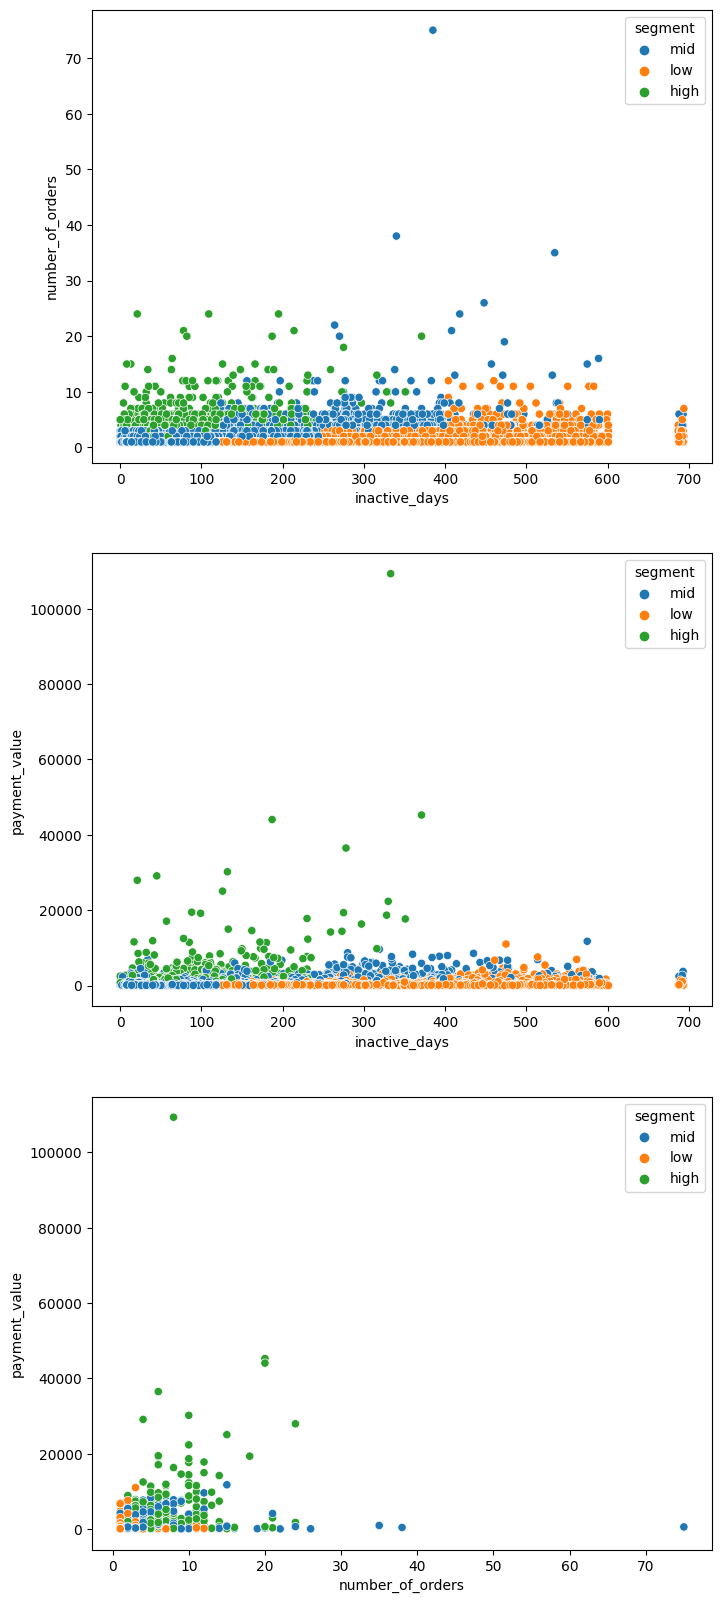

In [66]:
fig, ax = plt.subplots(3, 1, figsize=(8,20))
sns.scatterplot(x='inactive_days', y='number_of_orders', ax=ax[0], hue='segment', data=overall)
sns.scatterplot(x='inactive_days', y='payment_value', ax=ax[1], hue='segment', data=overall)
sns.scatterplot(x='number_of_orders', y='payment_value', ax=ax[2], hue='segment', data=overall);

As seen from the scatterplots above, the RFM framework helps us to clearly differentiate the low, mid and high segments.

## Next steps

Now that we have identified our segments, each customer segment needs to be targeted differently:

High value: Maintain share of wallet. This can be done by personalising the shopping experience and introducing exclusive rewards to promote loyalty and advocacy.

Mid value: The mid segment (1.39 orders) has a much lower average order frequency than the high segment (5.35 orders). We should focus on improving frequency among mid value customers. Conduct A/B testing at various points of the customer journey (eg. search, product page) to improve conversion rate. We can also investigate if customers have had a bad experience which is deterring them from purchasing more frequently. Addressing these pain points will be crucial in driving frequency.

Low value: This group has very high platform inactivity, averaging at 310 inactive days. Awareness may be an issue with this group. Invest in paid ads, content marketing and organic social media posts to improve general awareness about Olist and its value proposition. After which, introduce gamification to encourage habitual platform use.